# Faster Superconvergence on CIFAR10 with PyTorch

In this notebook we demonstrate a 30% speedup of [superconvergence](https://arxiv.org/pdf/1708.07120.pdf) via [ReZero](https://arxiv.org/pdf/2003.04887.pdf). We closely follow the fast.ai [setup](https://github.com/fastai/imagenet-fast), which demonstrates training to 94% accuracy after 65 epochs. ReZero facilitates the same accuracy after 45 epochs, with outherwise identical architecture, hyperparameters and optimizer. The ReZero architecture modification accelerates training and thus the model can tolerate a steeper initial learning rate schedule.

This notebook is based in part on Hongyi Zhang's [repo](https://github.com/hongyi-zhang/Fixup).

In [1]:
'''Faster Superconvergence on CIFAR10 with PyTorch.'''

from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import csv
import numpy
import random

from customonecycle import CustomOneCycleLR

import models

from utils import mixup_data, mixup_criterion


model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

print('Available Models: \n')
print(', '.join(model_names)) 

print('Torch version: ' + str(torch.__version__)) #There have been version dependent results

Available Models: 

dpn26, dpn92, fixup_resnet110, fixup_resnet1202, fixup_resnet20, fixup_resnet32, fixup_resnet44, fixup_resnet56, nobn_rezero_resnet56, preactresnet101, preactresnet152, preactresnet18, preactresnet34, preactresnet50, resnet110, resnet1202, resnet20, resnet32, resnet44, resnet56, rezero_dpn26, rezero_dpn92, rezero_preactresnet101, rezero_preactresnet152, rezero_preactresnet18, rezero_preactresnet34, rezero_preactresnet50, rezero_resnet110, rezero_resnet1202, rezero_resnet20, rezero_resnet32, rezero_resnet44, rezero_resnet56, rezero_resnet602
Torch version: 1.2.0


In [2]:
#######################################
# Input parameters

args_input = [
   '-a', 'rezero_preactresnet18',
    '--seed', '6892',
    '--sess', 'superc', 
    '--batchsize','512',
    '--progress_bar', 'False',
    '--init_lr', '.032',
    '--point_1_lr', '1.2',
    '--point_1_step', '0.1',
    '--point_2_lr', '0.032',
    '--point_2_step', '0.9',
    '--n_epoch', '45',
    '--decay', '2e-4',
    '--resweight_lr', '0.1'
]

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Using 1 GPUs.
Using CUDA..


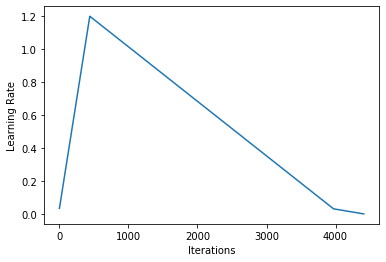

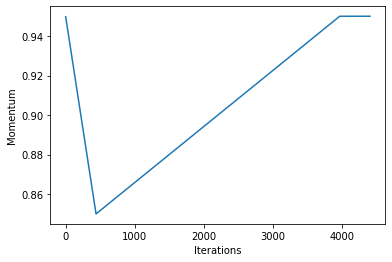

In [3]:
#######################################
# Parser

parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('-a', '--arch', metavar='ARCH', default='rezero_preactresnet18', choices=model_names, help='model architecture: ' +
                        ' | '.join(model_names) + ' (default: fixup_resnet110)')
parser.add_argument('--sess', default='superc', type=str, help='session id')
parser.add_argument('--seed', default=random.randint(0,10000), type=int, help='rng seed')
parser.add_argument('--decay', default=2e-4, type=float, help='weight decay (default=2e-4)')
parser.add_argument('--batchsize', default=512, type=int, help='batch size per GPU (default=512)')
parser.add_argument('--n_epoch', default=45, type=int, help='total number of epochs')
parser.add_argument('--init_lr', default=0.032, type=float)
parser.add_argument('--point_1_step', default = 0.1, type=float)
parser.add_argument('--point_1_lr', default = 1.2, type=float)
parser.add_argument('--point_2_step', default = 0.9, type=float)
parser.add_argument('--point_2_lr', default = 0.032, type=float)
parser.add_argument('--end_lr', default=0.001, type=float)
parser.add_argument('--resweight_lr', default=0.1, type=float)
parser.add_argument('--momentum_range', default=(0.85, 0.95), type=tuple)
parser.add_argument('--exp_decay', default=False, type=bool)
parser.add_argument('--progress_bar', default=True, type=bool, help='display progress bar')


global arg
args = parser.parse_args(args_input); args
args.progress_bar = (args.progress_bar=='True')
if args.progress_bar:
    from utils import progress_bar


torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
numpy.random.seed(args.seed)
random.seed(args.seed)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = args.batchsize
lr = args.init_lr


#######################################
# Data
print('==> Preparing data..')
normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
scale_size = 40
size=32
padding = int((scale_size - size) / 2)
transform_train = transforms.Compose([
        transforms.RandomCrop(size, padding=4),
        transforms.ColorJitter(.25,.25,.25),
        transforms.RandomRotation(2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize,])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


#######################################
# Model
net = models.__dict__[args.arch]()

if use_cuda:
    net.cuda()
    print('Using', torch.cuda.device_count(), 'GPUs.')
    cudnn.benchmark = True
    print('Using CUDA..')


#######################################
#Define criterion, optimizer and scheduler

criterion = nn.CrossEntropyLoss().cuda()

parameters_others = [p[1] for p in net.named_parameters() if not ('resweight' in p[0])]
parameters_resweight = [p[1] for p in net.named_parameters() if 'resweight' in p[0]]

#Optimizer for most parameters, following schedule
optimizer = optim.SGD([
        {'params': parameters_others, 'lr': 0.01}],weight_decay = args.decay)

scheduler = CustomOneCycleLR(optimizer, 
                             num_steps = args.n_epoch * len(trainloader),
                             init_lr = args.init_lr,
                             point_1 = (args.point_1_step,args.point_1_lr),
                             point_2 = (args.point_2_step,args.point_2_lr),
                             end_lr = args.end_lr,
                             momentum_range = args.momentum_range,
                             exp_decay = args.exp_decay,
                             param_group = 0)

#Adagrad optimizer for resweights, constant lr.
optimizer_resweight = optim.Adagrad([
        {'params': parameters_resweight, 'lr': args.resweight_lr}])


#Print lr/momentum schedule
scheduler.test_plt()


#######################################
#Define train, test and log functions

def train(epoch):
    #print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs = net(inputs)
        optimizer.zero_grad()
        optimizer_resweight.zero_grad()
        loss = criterion( outputs,targets )
        loss.backward()
        optimizer.step()
        optimizer_resweight.step()
        scheduler.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (torch.sum(predicted == targets.data)).cpu()
        
        acc = (100.*float(correct)/float(total))
        if args.progress_bar:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), acc, correct, total))

    return (train_loss/batch_idx, acc)

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion( outputs,targets )

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            if args.progress_bar:
                progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (test_loss/(batch_idx+1), 100.*float(correct)/float(total), correct, total))

        # Save checkpoint.
        acc = 100.*float(correct)/float(total)
        if acc > best_acc:
            best_acc = acc
            checkpoint(acc, epoch)

    return (test_loss/batch_idx, acc)

def checkpoint(acc, epoch):
    # Save checkpoint.
    #print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + args.arch + '_' + args.sess + '_' + str(args.seed) + '.ckpt')


result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
logname = result_folder + args.arch + '_' + args.sess + '_' + str(args.seed) + '.csv'



if not os.path.exists(logname):
    with open(logname[:-4]+'_args.csv', 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['filename = '+logname,'arch = ' +args.arch, 'batchsize = '+str(args.batchsize), 'decay = '+ str(args.decay),
                          'n_epoch = ' +str(args.n_epoch),  'seed = '+str(args.seed) , 'sess = '+args.sess,
                           'num_steps = ' + str(args.n_epoch * len(trainloader)),
                            ' init_lr = ' + str (args.init_lr),
                             ' point_1 = ' + str ( (args.point_1_step,args.point_1_lr) ),
                             ' point_2 = ' + str ( (args.point_2_step,args.point_2_lr) ),
                             ' end_lr = ' + str ( args.end_lr ),
                             ' momentum_range = ' + str ( args.momentum_range),
                             ' exp_decay = ' + str ( args.exp_decay),
                             ' resweight_lr = ' + str (args.resweight_lr)])
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'lr', 'train loss', 'train acc', 'test loss', 'test acc'])

def print_resweights(epoch = 0):
    resweights = '|' + str(epoch) + ' resweights: ['
    for p in parameters_resweight:
        resweights += "{:1.2f}, ".format(p[0])
    resweights = resweights[:-2]+']'
    print(resweights)

In [4]:
#######################################
#Train the model

print('Training...')

for epoch in range(start_epoch, args.n_epoch):
    epoch_time = time.time()
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    epoch_time = time.time() - epoch_time
    print('|{:2d}: |{:2.0f}s |'
          'lr {:02.3f} | '
          'train/test loss {:1.2f}/{:1.2f} |train/test acc {:2.2f}%/{:2.2f}% (best: {:2.2f}%)|'.format(
            epoch,epoch_time,  optimizer.param_groups[0]['lr'],
            train_loss,test_loss, train_acc,  test_acc,best_acc))
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, optimizer.param_groups[0]['lr'], train_loss, train_acc, test_loss, test_acc])

print('Training complete. Best test accuracy {:2.2f}% after {:2.0f} epochs.'.format(best_acc,args.n_epoch))

Training...
| 0: |38s |lr 0.292 | train/test loss 1.77/1.71 |train/test acc 34.65%/41.88% (best: 41.88%)|
| 1: |37s |lr 0.551 | train/test loss 1.27/1.32 |train/test acc 54.65%/58.09% (best: 58.09%)|
| 2: |38s |lr 0.811 | train/test loss 0.98/1.19 |train/test acc 65.42%/61.52% (best: 61.52%)|
| 3: |37s |lr 1.070 | train/test loss 0.81/1.32 |train/test acc 72.10%/62.12% (best: 62.12%)|
| 4: |37s |lr 1.184 | train/test loss 0.68/1.05 |train/test acc 76.69%/68.93% (best: 68.93%)|
| 5: |36s |lr 1.151 | train/test loss 0.61/1.36 |train/test acc 79.42%/64.11% (best: 68.93%)|
| 6: |37s |lr 1.119 | train/test loss 0.56/0.81 |train/test acc 80.86%/74.84% (best: 74.84%)|
| 7: |36s |lr 1.086 | train/test loss 0.51/0.97 |train/test acc 82.54%/72.46% (best: 74.84%)|
| 8: |36s |lr 1.054 | train/test loss 0.49/0.69 |train/test acc 83.49%/78.30% (best: 78.30%)|
| 9: |35s |lr 1.022 | train/test loss 0.46/0.87 |train/test acc 84.44%/76.18% (best: 78.30%)|
|10: |36s |lr 0.989 | train/test loss 0.45/0.64 